In [2]:
# Build EyeNet on CIFAR10
# Torch Tensor Versioplotf CompressNode
import sys
conv3d_path = '/mnt/d/Implementation/VD/3DConv/utils'
sys.path.append(conv3d_path)
# QuadTree Img Compression Package
from quadtree import *
from model_idea import *
from experiment_model import *
from mid_select_test import *
from high_selection_experiment import *

In [30]:
# SetUp Test Script Environment -- We are running Experiments for now
# 1st Round: Supervise Accuracy Only -- Does it gets to the same level?
# 2nd Round: What level of cost reduction is possible here?
# 3rd Round: Goes to other tasks here ...

# How to argue for the improvement?
# Only if we achieve cost reduction here !! 
# Using Full features v.s. Using less features

In [3]:
import json

# read n visualize
def read_model(config_no):
    config_path = '/mnt/d/Implementation/VD/3DConv/config'
    config_names = ['r1_acc_loss_compare_4layer_eyemix',
                 'r1_acc_loss_compare_4layer_convmix',
                 'r1_acc_loss_compare_3layer_convmix',
                 'r1_acc_loss_compare_3layer_eyemix',
                 'r1_acc_loss_compare_2layer_eyemix',
                 'r1_acc_loss_compare_2layer_convmix',
                 'r1_acc_loss_compare_1layer_convmix',
                 'r1_acc_loss_compare_1layer_eyemix']
    config_name = config_names[config_no]
    print('Preparing with Config: ', config_name)
    config_file = f'{config_path}/{config_name}.json'
    args = read_args(config_file)

    # Read CIFAR10 dataset
    trainset, testset, trainloader, testloader = prepare_cifar10(args)

    if not args.eyemix:
        model = ConvMixer(dim=args.pconv_feature_dim,
                        depth=args.mixer_depth,
                        kernel_size=args.mixer_kernel_size,
                        patch_size=args.pconv_patch_size,
                        n_classes=args.num_classes)
    else:
        model = EyeMixer(args)
        
    # Load checkpoint
    checkpoint_path = f'{config_path}/{config_name}_{args.epochs-1}.pth'
    ckpt = torch.load(checkpoint_path)
    model.load_state_dict(ckpt['model_state_dict'])
    # Load training logs
    json_file = f'{config_path}/{config_name}_train_info.json'
    # Open the .json file for reading
    with open(json_file, 'r') as info_file:
        info = json.load(info_file)
        
    plt.plot(info['epochs'], info['train_acc'])
    plt.xlabel('Epochs')
    plt.ylabel('Train-Accuracy')
    return model, info, testset, args

Preparing with Config:  r1_acc_loss_compare_4layer_eyemix
Files already downloaded and verified
Files already downloaded and verified


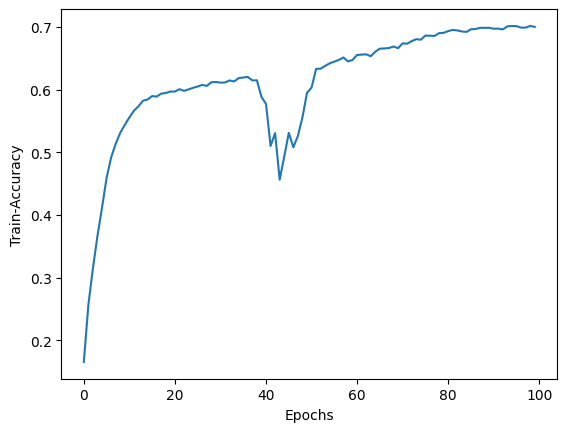

In [5]:
model, info, testset, args = read_model(0)

Visualization


feature_0,residual_0,bird

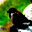

feature_1,mask_1,prob_1,residual_1,bird

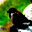

feature_2,mask_2,prob_2,residual_2,bird

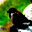

feature_3,mask_3,prob_3,residual_3,bird

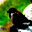

In [29]:
# Visualization
print('Visualization')

idx = np.random.choice(len(testset))
ch_idx = np.random.choice(args.pconv_feature_dim)
img, label = testset[idx]
res = model(img.unsqueeze(0))
for layer in range(args.num_layer):
    if layer==0:
        d = {f'feature_{layer}': normalize(res[f'feature_{layer}'][0][ch_idx]).cpu().detach().numpy(),
         # f'mask_{layer}': res[f'mask_{layer}'][0].squeeze(0).cpu().detach().numpy(),
         # f'prob_{layer}': res[f'prob_{layer}'][0].squeeze(0).cpu().detach().numpy(),
         f'residual_{layer}': normalize(res[f'residual_{layer}'][0][ch_idx]).squeeze().cpu().detach().numpy(),
         f'{cifar10_label_to_name[label]}': img.permute(1,2,0)
        }
    else:
        d = {f'feature_{layer}': normalize(res[f'feature_{layer}'][0][ch_idx]).cpu().detach().numpy(),
             f'mask_{layer}': res[f'mask_{layer}'][0].squeeze(0).cpu().detach().numpy(),
             f'prob_{layer}': res[f'prob_{layer}'][0].squeeze(0).cpu().detach().numpy(),
             f'residual_{layer}': normalize(res[f'residual_{layer}'][0][ch_idx]).squeeze().cpu().detach().numpy(),
             f'{cifar10_label_to_name[label]}': img.permute(1,2,0)
            }
    media.show_images(d, height=300, vmin=0., vmax=1.)

PatchConv Structural Debate:

* Currently We uses concatenation:
--- Costly with extra dimension in channels. This is not aligned with the FPN upsmaple layer, which upsample the prev layers' coarser feature prediction, 

In [ ]:
class PatchConv(nn.Module):
    def __init__(self, feat_h, feat_w, dim_patch_feature=256, patch_size=2, residual=False, patchscale_h=1, patchscale_w=1, mode=1):
        super(PatchConv, self).__init__()
        self.residual = residual
        
        # Residual Connection & Feature Prediction
        if mode == 1:
            self.layer = self._make_residual_layer(residual, 
                                              dim_patch_feature,
                                              patch_size, 
                                              feat_h, feat_w)
        if mode == 2:
            self.layer = self._make_residual_layer2(residual,
                                                    dim_patch_feature,
                                                    patch_size)
    
    def _make_residual_layer(self, residual, dim_patch_feature, patch_size, feat_h, feat_w):
        if residual:
            layers = [
                nn.Conv2d(3 + dim_patch_feature, 3, 1),
                nn.Conv2d(3, dim_patch_feature, kernel_size=patch_size, stride=patch_size),
                nn.GELU(),
                GRN(feat_h, feat_w)
            ]

        else:
            layers = [
                nn.Conv2d(3, dim_patch_feature, kernel_size=patch_size, stride=patch_size),
                nn.GELU(),
                GRN(feat_h, feat_w)
            ]
        return nn.Sequential(*layers)
    
    # when residual=False, this is equivalent with ConvNet patch convolution sec
    def _make_residual_layer2(self, residual, dim_patch_feature, patch_size):
        hidden_dim = 3
        if residual:
            layers = [
                nn.Conv2d(3 + dim_patch_feature, hidden_dim, kernel_size=patch_size, stride=patch_size),
                nn.Conv2d(hidden_dim, dim_patch_feature, kernel_size=patch_size, stride=patch_size),
                nn.GELU(),
                nn.BatchNorm2d(dim_patch_feature)
            ]
        else:
            layers = [
                nn.Conv2d(3, dim_patch_feature, kernel_size=patch_size, stride=patch_size),
                nn.GELU(),
                nn.BatchNorm2d(dim_patch_feature)
            ]
        return nn.Sequential(*layers)

    def forward(self, x, feat=None):
        assert (feat is None) != self.residual
        
        if x.dim() == 3:
            x = x.unsqueeze(0)  # Add a batch dimension of size 1
        
        if self.residual:    
            upsampled_feat = F.interpolate(feat, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
            x = torch.cat((x, upsampled_feat), dim=1)
        
        residual = self.layer(x)
                
        return residual

In [107]:
patch_size = (2,2)
Dim = 8
p0 = PatchConv2d(3, Dim, patch_size=patch_size)
p1 = PatchConv2d(Dim, Dim, patch_size=patch_size)
p2 = PatchConv2d(Dim, Dim, patch_size=patch_size)

pinv0 = AugPatchConv2d(3, Dim, patch_size=patch_size)
pinv1 = AugPatchConv2d(3, Dim, patch_size=patch_size)
pinv2 = AugPatchConv2d(3, Dim, patch_size=patch_size)

f0 = img.unsqueeze(0)

f1 = p0(f0)

f2 = p1(f1)
f3 = p2(f2)
f2_ = pinv2(f0, f3)
f1_ = pinv1(f0, f2_)


PreAug Low channel info shape:  torch.Size([1, 3, 32, 32])
PostAug Low channel info shape:  torch.Size([1, 8, 32, 32])
PreAug LowSpatial Info shape:  torch.Size([1, 8, 4, 4])
PostAug LowSpatial Info shape:  torch.Size([1, 8, 16, 16])


RuntimeError: The size of tensor a (32) must match the size of tensor b (16) at non-singleton dimension 3

In [103]:
f0.shape, f1.shape, f2.shape, f3.shape

(torch.Size([1, 3, 32, 32]),
 torch.Size([1, 8, 16, 16]),
 torch.Size([1, 8, 8, 8]),
 torch.Size([1, 8, 4, 4]))

In [106]:
pinv2(f0, f3)

AssertionError: Patch Convolution on Low Channel Information gives Low Spatial Resolution

In [105]:
class PatchConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, patch_size):
        super(PatchConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        return self.conv(x)
    
# Inverse Patch-Conv requires extra information
# Otherwise Model Can hardly Retrive enough extra information on itself
class AugPatchConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, patch_size):
        super(AugPatchConv2d, self).__init__()
        self.out_channels = out_channels
        self.aug_channel_info = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.scale = (int(patch_size[0]**2), int(patch_size[1]**2))
        self.aug_spatial_info = lambda x: F.interpolate(x, scale_factor=self.scale, mode='nearest')
        self.conv = nn.Conv2d(out_channels, out_channels, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, lc_info, ls_info=None):
        # assert ls_info.shape[1]==self.out_channels, 'Low Spatial Resolution Information should have High Channel Information'
        # assert ls_info.shape[-1]*self.scale[-1] == lc_info.shape[-1], 'Patch Convolution on Low Channel Information gives Low Spatial Resolution'
        # assert ls_info.shape[-2]*self.scale[-2] == lc_info.shape[-2], 'Patch Convolution on Low Channel Information gives Low Spatial Resolution'
        print('PreAug Low channel info shape: ', lc_info.shape)
        lc_info = self.aug_channel_info(lc_info)
        print('PostAug Low channel info shape: ', lc_info.shape)
        if ls_info == None:
            info = lc_info
        else:
            print('PreAug LowSpatial Info shape: ', ls_info.shape)
            ls_info = self.aug_spatial_info(ls_info)
            print('PostAug LowSpatial Info shape: ', ls_info.shape)
            # Merge
            info = lc_info + ls_info
        
        deduction = self.conv(info)
        return deduction

In [38]:
# Compare Coarse2Fine with Fine2Coarse ConvNet for direct comparison

import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = torch.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# Example usage:
# model = ResNet18()


Namespace(acc_scale=1.0, batch_size=64, clip_norm=False, cost_scale=1.0, epochs=25, eyemix=True, jitter=0.1, lr_max=0.01, min_cost=40.0, mixer_depth=2, mixer_kernel_size=5, name='EyeMixer', num_classes=10, num_layer=4, pconv_feature_dim=32, pconv_mode=1, pconv_patch_scale=[2, 2], pconv_patch_size=[2, 2], penalize_cost=True, preprocess_img_size=[32, 32], ra_m=8, ra_n=1, reprob=0.25, scale=0.75, sparsity_ratio=0.5, subimg_size=[4, 4], use_temperature_schedule=False, wd=0.01, window_size_sma=50, workers=2)

In [34]:
# Feature Extraction from QuadVision
class ConvFeat(nn.Module):
    def __init__(self, args):
        super(ConvFeat, self).__init__()
        self.num_layer = args.num_layer
        self.subimg_size = args.subimg_size
        self.patch_size = args.pconv_patch_size
        self.patchscale_h = args.pconv_patch_scale[0]
        self.patchscale_w = args.pconv_patch_scale[1]
        self.dim_patch_feature = args.pconv_feature_dim
        self.mode = 'gumbel'
        
        self._make_layers(mode=1)
              
        
    def _make_layers(self, mode):
        self.subimgs_size = []
        # Fine2Coarse Instead -- Conventional Convolution Structure
        for layer in range(self.num_layer):
            if layer == 0:
                # ChannelSize 3->Dim & Spatial Resolution shrink by half
                feature_layer = nn.Conv2d(3, self.dim_patch_feature, self.patch_size)
            else:
                feature_layer = nn.Conv2d(self.dim_patch_feature, self.dim_patch_feature, self.)
            setattr(self, f'feature_layer_{layer}')
                
            
        for layer in range(self.num_layer):
            subimgs_size = self.subimg_size[0]*2**layer, self.subimg_size[1]*2**layer
            self.subimgs_size.append(subimgs_size)
            feature_layer = PatchConv(feat_h = subimgs_size[0]//self.patch_size[0],
                                  feat_w = subimgs_size[1]//self.patch_size[1],
                                  dim_patch_feature = self.dim_patch_feature,
                                  residual = (layer!=0),
                                  patch_size = self.patch_size,
                                  patchscale_h = self.patchscale_h,
                                  patchscale_w = self.patchscale_w,
                                  mode = mode)
            setattr(self, f'feature_layer_{layer}', feature_layer)
            
            mask_layer = ConvGate(self.patchscale_h, self.patchscale_w,
                                  self.dim_patch_feature, self.mode)
            setattr(self, f'mask_layer_{layer}', mask_layer)
            
        self.output_size = subimgs_size[0]//self.patch_size[0], subimgs_size[1]//self.patch_size[1]
            
    def forward(self, x, temperature = 1.0):
        total_forward_time = 0
        stat = {}
        f,m,p,next_m,next_p,res = None,None,None,None,None,{}
        for layer in range(self.num_layer):
            
            t0 = time.time()
            m = ensemble_update(m, next_m, mode='prod')
            p = ensemble_update(p, next_p, mode='prod')
            subimgs = F.interpolate(x, (self.subimg_size[0]*2**layer, self.subimg_size[1]*2**layer), mode='bilinear', align_corners=True)
            
            t1 = time.time()
            stat[f'Layer {layer} Upsample Time'] = t1-t0
            
            
            # print(f'Layer {layer} | SubImg Size: {subimgs.shape}')
            r = getattr(self, f'feature_layer_{layer}')(subimgs, f)
            
            t2 = time.time()
            stat[f'Layer {layer} PatchConvolution Time'] = t2-t1
            
            
            # print(f'-- Residual shape: {r.shape}')
            getattr(self, f'mask_layer_{layer}').temperature = temperature
            next_m, next_p, next_l = getattr(self, f'mask_layer_{layer}')(r)
            
            # next_m, next_p, next_l, next_h = self.control(r, h)
            t3 = time.time()
            stat[f'Layer {layer} Gating Time'] = t3-t2
            
            f = ensemble_mask_addition(f, r, m)
            t4 = time.time()
            stat[f'Layer {layer} Ensemble Mask Addition'] = t4-t3
            
            res[f'feature_{layer}'] = f
            res[f'mask_{layer}'] = m # Current Layer's Adpopted Mask get recorded
            res[f'prob_{layer}'] = p
            res[f'residual_{layer}'] = r
            
        res['feature'] = f
        res['mask'] = m
        res['prob'] = p

        return res, stat
    

EyeMixer(
  (feature_extractor): EyeFeat(
    (feature_layer_0): PatchConv(
      (layer): Sequential(
        (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
        (1): GELU(approximate='none')
        (2): GRN()
      )
    )
    (mask_layer_0): ConvGate(
      (downsample): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
      (proj): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
      (prob): Sigmoid()
    )
    (feature_layer_1): PatchConv(
      (layer): Sequential(
        (0): Conv2d(35, 3, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
        (2): GELU(approximate='none')
        (3): GRN()
      )
    )
    (mask_layer_1): ConvGate(
      (downsample): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
      (proj): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
      (prob): Sigmoid()
    )
    (feature_layer_2): PatchConv(
      (layer): Sequential(
        (0): Conv2d(35, 3, kernel_size=(1, 1), st

In [2]:
config_path = '/mnt/d/Implementation/VD/3DConv/config'
config_names = ['r1_acc_loss_compare_1layer_eyemix']
config_name = config_names[0]
print('Preparing with Config: ', config_name)
config_file = f'{config_path}/{config_name}.json'
args = read_args(config_file)
model = EyeMixer(args)

Preparing with Config:  r1_acc_loss_compare_1layer_eyemix


In [33]:
args.penalize_cost = True

In [8]:
efeat = EyeMixer(args).feature_extractor
# Bug in the propagation with num_layer = 1 here
inp = torch.randn(1,3,32,32)


In [29]:
self = efeat
x = inp
f,m,p,next_m,next_p,res = None,None,None,None,None,{}
for layer in range(self.num_layer):
    m = ensemble_update(m, next_m, mode='prod')
    p = ensemble_update(p, next_p, mode='prod')
    subimgs = F.interpolate(x, (self.subimg_size[0]*2**layer, self.subimg_size[1]*2**layer), mode='bilinear', align_corners=True)
    r = getattr(self, f'feature_layer_{layer}')(subimgs, f)
    
    next_m, next_p, next_l = getattr(self, f'mask_layer_{layer}')(r)
    
    f = ensemble_mask_addition(f, r, m)

In [24]:
ensemble_mask_addition

<function mid_select_test.ensemble_mask_addition(ensemble, feat, mask)>

In [68]:
def parse_eyemixer_args(comm = []):
    parser = argparse.ArgumentParser(
                        prog='HumanViewer',
                        description='Perception like Human -- Learnable Image Perception with QuadTreeNodes',
                        epilog='Text at the bottom of help')
    
    parser.add_argument('--name', type=str, default="EyeMixer")
        
    parser.add_argument('-num_layer', '--num_layer', default=1, type=int)
    parser.add_argument('-imsize', '--preprocess_img_size', default='384,768', type=str)  # Accept as a comma-separated string
    parser.add_argument('-pconv_dim', '--pconv_feature_dim', default=3, type=int)
    parser.add_argument('-pconv_scale', '--pconv_patch_scale', default='6,12', type=str)  # Accept as a comma-separated string
    parser.add_argument('-depth', '--mixer_depth', default=4, type=int)
    parser.add_argument('-conv_ks', '--mixer_kernel_size', default=5, type=int)
    parser.add_argument('-n_classes', '--num_classes', default=10, type=int)
    parser.add_argument('-m', '--pconv_mode', default=1, type=int) # ['ste', 'gumbel'] for Pconv Mode
    
    parser.add_argument('--wd', default=0.01, type=float)
    parser.add_argument('--acc_scale', default=1., type=float)
    parser.add_argument('--cost_scale', default=1., type=float)
    parser.add_argument('--sparsity_ratio', default=0.5, type=float)
    parser.add_argument('--min_cost', default=40., type=float)
    parser.add_argument('--window_size_sma', default=50, type=int)
    
    parser.add_argument('--clip-norm', action='store_true')
    parser.add_argument('-bs', '--batch-size', default=128, type=int)
    parser.add_argument('--epochs', default=25, type=int)
    parser.add_argument('--lr-max', default=0.01, type=float)
    parser.add_argument('--workers', default=2, type=int)
    parser.add_argument('--scale', default=0.75, type=float)
    parser.add_argument('--reprob', default=0.25, type=float)
    parser.add_argument('--ra-m', default=8, type=int)
    parser.add_argument('--ra-n', default=1, type=int)
    parser.add_argument('--jitter', default=0.1, type=float)

    args = parser.parse_args(comm)
    process_args(args)
    
    return args

In [255]:
# json file path
config_path = '/mnt/d/Implementation/VD/3DConv/config'
import os
import glob

# smaller num_layer -> faster processing -> less selection
config_names = []
for num_layer in range(1, 5):
    num_layer = 1
    pconv_scale = int(2**(5-num_layer))
    args = parse_eyemixer_args(['-num_layer', str(num_layer),
                                '-pconv_dim', '32',
                                '-pconv_scale', f'{pconv_scale},{pconv_scale}',
                                '-depth', '2',
                                '-imsize', '32, 32',
                                '-bs', '64'])

    args.eyemix = True
    if args.eyemix:
        config_name = f'r1_acc_loss_compare_{num_layer}layer_eyemix'
    else:
        config_name = f'r1_acc_loss_compare_{num_layer}layer_convmix'
    args.use_temperature_schedule = False
    args.penalize_cost = False
    save_args(args, config_path +'/'+ config_name + '.json')

    config_names.append(config_name)
    
    args.eyemix = False
    if args.eyemix:
        config_name = f'r1_acc_loss_compare_{num_layer}layer_eyemix'
    else:
        config_name = f'r1_acc_loss_compare_{num_layer}layer_convmix'
    args.use_temperature_schedule = False
    args.penalize_cost = False
    save_args(args, config_path +'/'+ config_name + '.json')

    config_names.append(config_name)

In [258]:
args.eyemix

True

In [179]:
trainset, testset, trainloader, testloader = prepare_cifar10(args)

In [207]:
args

Namespace(acc_scale=1.0, batch_size=3, clip_norm=False, convmix=False, cost_scale=1.0, epochs=25, jitter=0.1, lr_max=0.01, min_cost=40.0, mixer_depth=1, mixer_kernel_size=5, name='EyeMixer', num_classes=10, num_layer=3, pconv_feature_dim=64, pconv_mode=1, pconv_patch_scale=(4, 4), pconv_patch_size=(2, 2), penalize_cost=False, preprocess_img_size=(32, 32), ra_m=8, ra_n=1, reprob=0.25, scale=0.75, sparsity_ratio=0.5, subimg_size=(8, 8), use_temperature_schedule=False, wd=0.01, window_size_sma=50, workers=2)

In [209]:
if args.convmix:
    model = ConvMixer(dim=args.pconv_feature_dim,
                    depth=args.mixer_depth,
                    kernel_size=args.mixer_kernel_size,
                    patch_size=args.pconv_patch_size,
                    n_classes=args.num_classes)
else:
    model = EyeMixer(args)
    
model = nn.DataParallel(model).cuda()

lr_schedule = lambda t: np.interp([t], [0, args.epochs*2//5, args.epochs*4//5, args.epochs], 
                                  [0, args.lr_max, args.lr_max/20.0, 0])[0]
opt = optim.AdamW(model.parameters(), lr=args.lr_max, weight_decay=args.wd)
criterion = SetCriterion(args)

if args.penalize_cost:
    losses_use = ['acc', 'cost']
else:
    losses_use = ['acc']

criterion.update_param(losses=losses_use) 

scaler = torch.cuda.amp.GradScaler()

if args.use_temperature_schedule:
    tem_schedule = lambda t: max(5. - 8. * (t/args.epochs), 1.0)
else:
    tem_schedule = lambda t: 1.
    
training_info = {'epochs': [], 'train_acc': [], 'test_acc': []}

for epoch in range(args.epochs):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(trainloader):
        model.train()
        X, y = X.cuda(), y.cuda()

        lr = lr_schedule(epoch + (i + 1)/len(trainloader))
        opt.param_groups[0].update(lr=lr)

        opt.zero_grad()
        with torch.cuda.amp.autocast():
            if hasattr(model.module, 'feature_extractor'):
                output = model(X, temperature=tem_schedule(epoch))
            else:
                output = {'pred': model(X)}
                
            loss = criterion.loss_accuracy(output, y)[f'loss_acc_{args.num_layer-1}']
            # loss = criterion(output, y)['total']

        scaler.scale(loss).backward()
        if args.clip_norm:
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt)
        scaler.update()
        
        train_loss += loss.item() * y.size(0)
        train_acc += (output['pred'].max(1)[1] == y).sum().item()
        n += y.size(0)
        
    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            if not isinstance(output, dict):
                output = {'pred':output}
            test_acc += (output['pred'].max(1)[1] == y).sum().item()
            m += y.size(0)

    print(f'[{args.name}] Epoch: {epoch} | Train Acc: {train_acc/n:.4f}, Test Acc: {test_acc/m:.4f}, Time: {time.time() - start:.1f}, lr: {lr:.6f}')
    print(f'-- train loss: {train_loss}')
    
    training_info['epochs'].append(epoch)
    training_info['train_acc'].append(train_acc/n)
    training_info['test_acc'].append(test_acc/m)
    info_file = f'{config_path}/{config_name}_train_info.json'
    with open(info_file, 'w') as fp:
        json.dump(training_info, fp)
    
# Save checkpoint
checkpoint_path = f'{config_path}/{config_name}_{epoch}.pth'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.module.state_dict()
}, checkpoint_path)
print('CheckPoint File Saved')

[EyeMixer] Epoch: 0 | Train Acc: 0.2163, Test Acc: 0.3553, Time: 18.2, lr: 0.001000
-- train loss: 105520.03002929688
[EyeMixer] Epoch: 1 | Train Acc: 0.3701, Test Acc: 0.4608, Time: 16.2, lr: 0.002000
-- train loss: 87049.29829406738
[EyeMixer] Epoch: 2 | Train Acc: 0.4427, Test Acc: 0.5233, Time: 16.9, lr: 0.003000
-- train loss: 77359.00431060791
[EyeMixer] Epoch: 3 | Train Acc: 0.4803, Test Acc: 0.5438, Time: 16.9, lr: 0.004000
-- train loss: 73020.03964996338
[EyeMixer] Epoch: 4 | Train Acc: 0.4450, Test Acc: 0.5725, Time: 16.3, lr: 0.005000
-- train loss: 76814.25588607788
[EyeMixer] Epoch: 5 | Train Acc: 0.5350, Test Acc: 0.5935, Time: 17.7, lr: 0.006000
-- train loss: 65259.446657180786
[EyeMixer] Epoch: 6 | Train Acc: 0.3729, Test Acc: 0.3811, Time: 19.1, lr: 0.007000
-- train loss: 85278.92182540894


KeyboardInterrupt: 

#### (First Try)
* First Round does not work -- TrainAcc even goes down as training heppens here, need visualization to figure out what went wrong. | Training time is just too long, I need to break down, use less Mixing layers and speed up the iteration procesure, maybe only uses EyeFeat for a change here.

#### (Design 1) No penalty on Cost
* num_layer=2, backpropagate only through accuracy/regression loss, in this case, the discrete selection mechanism will likely be learned to non-masking scenarios. This makes me wonder: What is it that breaks the learning previsouly?
* num_layer=3, backpropagate only through accuracy/regression loss, in this case, loss starts to go down a bit, and then go UP (how is that even possible??), feature_dim=16 might have caused the issue, maybe the drop in performance during learning relates to the lack of expressive power.
* num_layer=3, shrink the feature_dim to 16, same setup now improves the neural network's performance during training to 60+ accuracy.

#### (Round 1 Experimental Design) No penalty on Cost, PatchConv v.s. EyeFeat
* One layer Eyemix, due to its obvious equivalence with Convmixer, gives similar performance with the Convmixer, however, 2layer Eyemix immediately shows a slower convergence (at least in 25 epochs, it lag behind in training accuracy here)
* Double Layer Eyemix needs some mixing to have good performnace here?

* 4layer Eyemix Achieves slightly better performance, compared with 1layer ConvMixer. 
* Such Slight Improvement is not good enough here, obvisouly !

Visualization


feature_1,mask_1,prob_1,residual_1,bird

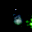

feature_2,mask_2,prob_2,residual_2,bird

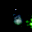

In [176]:
# Visualization
print('Visualization')

idx = np.random.choice(len(testset))
ch_idx = np.random.choice(args.pconv_feature_dim)
img, label = testset[idx]
res = model(img.unsqueeze(0).cuda())
for layer in range(1, args.num_layer):
    d = {f'feature_{layer}': res[f'feature_{layer}'][0][ch_idx].cpu().detach().numpy(),
         f'mask_{layer}': res[f'mask_{layer}'][0].squeeze(0).cpu().detach().numpy(),
         f'prob_{layer}': res[f'prob_{layer}'][0].squeeze(0).cpu().detach().numpy(),
         f'residual_{layer}': normalize(res[f'residual_{layer}'])[0][ch_idx].squeeze().cpu().detach().numpy(),
         f'{cifar10_label_to_name[label]}': img.permute(1,2,0)
        }
    media.show_images(d, height=300, vmin=0., vmax=1.)  